In [29]:
import ast
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from datasets import load_dataset
from scipy.stats import norm, multivariate_normal

seed = 42
np.random.seed(seed)

## Define Tag Categories

Define all possible tags for each category based on the dataset.

In [30]:
KNOWN_TAGS = json.load(open("../data/concepts_to_tags.json", "r"))

# Reverse map for easy lookup (tag -> category)
TAG_TO_CATEGORY = {}
for cat, tags in KNOWN_TAGS.items():
    for tag in tags:
        TAG_TO_CATEGORY[tag] = cat


## Load MTG Jaemdo dataset as a baseline

In [26]:
out_buffer = []

with open("../data/mtg_jamendo/autotagging_top50tags.tsv", "r") as f:
    for line in f.readlines():
        strings = line.strip().split('\t')
        track_id = strings[0]
        tags = strings[5:]  # Assuming tags start from the 6th column
        out_buffer.append({
            "id": track_id,
            "tags": tags
        })
with open("../data/mtg_jamendo/autotagging_top50tags_processed.csv", "w") as f:
    f.write("id,tags\n")
    for item in out_buffer:
        f.write(f"{item['id']},\"{';'.join(item['tags'])}\"\n")

In [27]:
mtg_df = pd.read_csv("../data/mtg_jamendo/autotagging_top50tags_processed.csv", converters={
    'tags': lambda x: x.split(';')
})
mtg_df

,id,tags
0,TRACK_ID,[TAGS]
1,track_0000215,[genre---metal]
2,track_0000216,[genre---metal]
3,track_0000219,[genre---metal]
4,track_0000223,[genre---metal]
...,...,...
54376,track_1422056,"[genre---soundtrack, instrument---computer]"
54377,track_1422057,"[genre---soundtrack, instrument---computer]"
54378,track_1422058,"[genre---soundtrack, instrument---computer]"
54379,track_1422059,"[genre---soundtrack, instrument---computer]"


In [28]:
# Parse tags into categories
def parse_tags(tags):
    return pd.Series({
        'genre_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'genre'],
        'mood_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'mood'],
        'instrument_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'instrument']
    })

def clean_tags(tags):
    _tags = ast.literal_eval(str(tags))
    _tags = [t.split('---')[-1].strip() for t in _tags]
    return [t.lower() for t in _tags if t.lower() in TAG_TO_CATEGORY]

mtg_df[['genre_tags', 'mood_tags', 'instrument_tags']] = mtg_df['tags'].apply(clean_tags).apply(parse_tags)
mtg_df['aspect_list'] = mtg_df.apply(lambda row: list(set(
    row['genre_tags'] + row['mood_tags'] + row['instrument_tags']
)), axis=1)
mtg_df

,id,tags,genre_tags,mood_tags,instrument_tags,aspect_list
0,TRACK_ID,[TAGS],[],[],[],[]
1,track_0000215,[genre---metal],[metal],[],[],[metal]
2,track_0000216,[genre---metal],[metal],[],[],[metal]
3,track_0000219,[genre---metal],[metal],[],[],[metal]
4,track_0000223,[genre---metal],[metal],[],[],[metal]
...,...,...,...,...,...,...
54376,track_1422056,"[genre---soundtrack, instrument---computer]",[],[],[],[]
54377,track_1422057,"[genre---soundtrack, instrument---computer]",[],[],[],[]
54378,track_1422058,"[genre---soundtrack, instrument---computer]",[],[],[],[]
54379,track_1422059,"[genre---soundtrack, instrument---computer]",[],[],[],[]


In [ ]:
mtg_df = mtg_df.where((mtg_df['genre_tags'].map(len) > 0) & (mtg_df['instrument_tags'].map(len) > 0)).dropna()
mtg_df

,id,tags,genre_tags,mood_tags,instrument_tags,aspect_list
607,track_0007391,"[genre---electronic, genre---pop, instrument--...","[electronic, pop]",[emotional],"[bass, drums, guitar, keyboard]","[drums, bass, guitar, electronic, emotional, p..."
1015,track_0015161,"[genre---instrumentalpop, genre---pop, genre--...","[pop, rock]",[emotional],"[bass, drums]","[drums, bass, rock, emotional, pop]"
1020,track_0015166,"[genre---dance, genre---electronic, genre---po...","[dance, electronic, pop, techno]",[emotional],[bass],"[bass, electronic, dance, techno, emotional, pop]"
1021,track_0015167,"[genre---chillout, genre---easylistening, genr...","[electronic, pop]",[emotional],"[bass, violin]","[bass, electronic, emotional, pop, violin]"
1023,track_0015169,"[genre---electronic, genre---instrumentalpop, ...","[electronic, pop]",[emotional],"[bass, drums]","[drums, bass, electronic, emotional, pop]"
...,...,...,...,...,...,...
54313,track_1420702,"[genre---dance, genre---easylistening, genre--...",[dance],"[funk, happy]","[bass, drums, keyboard]","[drums, bass, dance, funk, keyboard, happy]"
54314,track_1420704,"[genre---dance, genre---easylistening, instrum...",[dance],[happy],"[bass, drums, keyboard]","[drums, bass, dance, keyboard, happy]"
54315,track_1420705,"[genre---dance, genre---easylistening, instrum...",[dance],[happy],"[bass, drums, keyboard]","[drums, bass, dance, keyboard, happy]"
54316,track_1420706,"[genre---dance, genre---easylistening, instrum...",[dance],[happy],"[bass, drums, keyboard]","[drums, bass, dance, keyboard, happy]"


In [30]:
mtg_df.to_csv("../data/mtg_jamendo/autotagging_top50tags_processed_cleaned.csv", index=False)

## Generate causal tags

In [31]:
class MusicCapsGenerator:
    def __init__(self):
        self.tag_counts = Counter()
        self.co_occurrences = defaultdict(Counter)
        self.total_records = 0
        self.vocab = set()

    def train(self):
        print("Loading google/MusicCaps dataset...")
        # Load dataset from Hugging Face
        dataset = load_dataset("google/MusicCaps", split="train")
        
        print(f"Processing {len(dataset)} records...")
        
        for row in dataset:
            # MusicCaps stores tags as a string representation of a list: "['pop', 'tinny']"
            raw_aspect_list = row['aspect_list']
            
            try:
                # Parse string back to actual list
                tags_raw = ast.literal_eval(raw_aspect_list)
            except:
                continue

            # Filter tags: Keep only those in our taxonomy
            valid_tags = [t.lower() for t in tags_raw if t.lower() in TAG_TO_CATEGORY]
            
            if not valid_tags:
                continue

            self.total_records += 1
            
            # Update stats
            for tag in valid_tags:
                self.tag_counts[tag] += 1
                self.vocab.add(tag)
                for other_tag in valid_tags:
                    if tag != other_tag:
                        self.co_occurrences[tag][other_tag] += 1

        print("Training complete.")

    def get_probability(self, target_tag, context_tag):
        """P(Context | Target) with Laplace smoothing"""
        overlap = self.co_occurrences[target_tag][context_tag]
        target_count = self.tag_counts[target_tag]
        # Smoothing prevents division by zero or zero probability
        return (overlap + 1) / (target_count + len(self.vocab))

    def generate(self, seed_tags, target_category, temperature=1.0):
        """
        Generates a tag for the target_category.
        
        Args:
            seed_tags (list): Tags you already have (e.g. ['rock', 'guitar'])
            target_category (str): 'genre', 'instrument', 'mood', or 'tempo'
            temperature (float): 
                < 1.0 = Conservative (picks most likely tag)
                1.0   = Standard probability
                > 1.0 = Creative (picks diverse/risky tags)
        """
        candidates = list(KNOWN_TAGS.get(target_category, []))
        scores = []
        
        # Clean seeds to match our vocabulary
        seeds = [s.lower() for s in seed_tags if s.lower() in self.vocab]

        for candidate in candidates:
            # Don't predict a tag we already have
            if candidate in seeds:
                scores.append(0)
                continue
                
            # 1. Prior: P(Candidate)
            prior = self.tag_counts[candidate] / self.total_records
            
            # 2. Likelihood: P(Seeds | Candidate)
            likelihood = 1.0
            for seed in seeds:
                likelihood *= self.get_probability(candidate, seed)
            
            raw_score = prior * likelihood
            scores.append(raw_score)

        # --- TEMPERATURE SCALING ---
        scores = np.array(scores)
        
        # Avoid log(0) issues
        scores = np.clip(scores, 1e-9, None) 
        
        if temperature != 1.0:
            # Apply temperature to log probabilities, then exponentiate back
            # Formula: exp(log(p) / temp)
            log_scores = np.log(scores)
            scores = np.exp(log_scores / temperature)

        # Normalize to sum to 1
        total_score = np.sum(scores)
        if total_score == 0:
            return None
            
        probs = scores / total_score
        
        # Sample
        chosen_tag = np.random.choice(candidates, p=probs)
        return chosen_tag

In [32]:
generator = MusicCapsGenerator()
generator.train()

Loading google/MusicCaps dataset...
Processing 5521 records...
Training complete.


In [33]:
df = pd.read_csv("../data/mtg_jamendo/autotagging_top50tags_processed_cleaned.csv")
df['aspect_list'] = df['aspect_list'].apply(ast.literal_eval)
df

,id,tags,genre_tags,mood_tags,instrument_tags,aspect_list
0,track_0007391,"['genre---electronic', 'genre---pop', 'instrum...","['electronic', 'pop']",['emotional'],"['bass', 'drums', 'guitar', 'keyboard']","[drums, bass, guitar, electronic, emotional, p..."
1,track_0015161,"['genre---instrumentalpop', 'genre---pop', 'ge...","['pop', 'rock']",['emotional'],"['bass', 'drums']","[drums, bass, rock, emotional, pop]"
2,track_0015166,"['genre---dance', 'genre---electronic', 'genre...","['dance', 'electronic', 'pop', 'techno']",['emotional'],['bass'],"[bass, electronic, dance, techno, emotional, pop]"
3,track_0015167,"['genre---chillout', 'genre---easylistening', ...","['electronic', 'pop']",['emotional'],"['bass', 'violin']","[bass, electronic, emotional, pop, violin]"
4,track_0015169,"['genre---electronic', 'genre---instrumentalpo...","['electronic', 'pop']",['emotional'],"['bass', 'drums']","[drums, bass, electronic, emotional, pop]"
...,...,...,...,...,...,...
2036,track_1420702,"['genre---dance', 'genre---easylistening', 'ge...",['dance'],"['funk', 'happy']","['bass', 'drums', 'keyboard']","[drums, bass, dance, funk, keyboard, happy]"
2037,track_1420704,"['genre---dance', 'genre---easylistening', 'in...",['dance'],['happy'],"['bass', 'drums', 'keyboard']","[drums, bass, dance, keyboard, happy]"
2038,track_1420705,"['genre---dance', 'genre---easylistening', 'in...",['dance'],['happy'],"['bass', 'drums', 'keyboard']","[drums, bass, dance, keyboard, happy]"
2039,track_1420706,"['genre---dance', 'genre---easylistening', 'in...",['dance'],['happy'],"['bass', 'drums', 'keyboard']","[drums, bass, dance, keyboard, happy]"


In [34]:
def generate_df(tags_per_category: dict[str, int], temperature=1.0):
    res_df = []
    for idx, row in df.iterrows():
        seed_tags = row['aspect_list']
        
        generated_tags = {}
        for category in ['genre', 'instrument', 'mood', 'tempo']:
            tags = []
            for _ in range(tags_per_category.get(category, max(0, len(seed_tags[f"{category}_tags"]) - len(seed_tags[f"{category}_tags"])))):
                tags.append(generator.generate(seed_tags, target_category=category, temperature=temperature))
            generated_tags[f'generated_{category}_tags'] = tags

        enriched_tags = seed_tags + \
            generated_tags['generated_genre_tags'] + \
            generated_tags['generated_instrument_tags'] + \
            generated_tags['generated_mood_tags'] + \
            generated_tags['generated_tempo_tags']
        
        res_entry = {
            'id': row['id'],
            'original_aspect_list': seed_tags,
            'aspect_list': enriched_tags,
            **generated_tags
        }
        res_df.append(res_entry)
    return pd.DataFrame(res_df)

In [35]:
CATEGORIES = [
    "Tempo",
    "Genre",
    "Mood",
    "Instrument"
]
N_CATEGORIES = len(CATEGORIES)
N_SAMPLES_TO_GENERATE = len(df)

# --- 1. SYNTHETIC DATA GENERATION (Replace with your actual data) ---
# We simulate a dataset where tag counts are discrete and correlated.
# Max counts are defined for simulation purposes.
MAX_COUNTS = {
    "Tempo": 4,
    "Genre": 4, 
    "Mood": 5, 
    "Instrument": 6, 
}
MEANS = {
    "Tempo": 1.24,
    "Genre": 1.46, 
    "Mood": 1.71, 
    "Instrument": 1,
}

In [36]:
def generate_synthetic_correlated_data(n_records):
    """
    Creates synthetic discrete count data that serves as the 'real' dataset.
    This step is highly important: it determines the statistics (R and ECDFs)
    that the Copula will try to match.
    """
    print("--- 1. Generating Synthetic Data ---")

    # Define the desired correlation matrix (e.g., high correlation between Genre and Instrument)
    # This represents your calculated correlation matrix R.
    correlation_matrix = np.array([
        [1.0, 0.2, 0.1, 0.03],  # Tempo
        [0.2, 1.0, 0.3, -0.01],  # Genre
        [0.1, 0.12, 1.0, -0.05],  # Mood
        [0.03, -0.01, -0.05, 1.0]   # Instrument
    ])

    # Generate correlated continuous data (Multivariate Normal)
    mean = np.zeros(N_CATEGORIES)
    z_continuous = multivariate_normal.rvs(mean=mean, cov=correlation_matrix, size=n_records)

    data = np.zeros((n_records, N_CATEGORIES), dtype=int)
    
    # Transform continuous data into discrete counts based on desired marginals
    # (using inverse CDF of an arbitrary discrete distribution for simulation)
    # This simulates your real-world data having specific tag count distributions
    for i, cat in enumerate(CATEGORIES):
        max_c = MAX_COUNTS[cat]
        if cat != "Instrument":
            # Simulate exponential-like distribution (more low counts than high)
            lam = 1.0 / MEANS[cat]
            x = np.arange(1, max_c + 1)
            p = (lam * np.exp(-lam * x))
            p /= p.sum()  # Normalize to sum to 1
        else:
            # Normal distribution
            mu = MEANS[cat]
            sigma = 1.37  # Standard deviation, adjust as needed
            x = np.arange(1, max_c + 1)
            p = norm.pdf(x, loc=mu, scale=sigma)
            p /= p.sum()  # Normalize to sum to 1
        
        # Convert continuous z (uniform quantile) to discrete count (inverse CDF)
        uniform_quantiles = norm.cdf(z_continuous[:, i])
        
        # Quantile mapping for a simple discrete distribution
        counts = np.digitize(uniform_quantiles, np.cumsum(p[:-1])) + 1
        data[:, i] = np.clip(counts, 1, max_c)

    print(f"Synthetic Data Shape: {data.shape}")
    print(f"Calculated Correlation of Synthetic Data:\n{np.corrcoef(data.T).round(2)}")
    return data, correlation_matrix

In [37]:
data, _ = generate_synthetic_correlated_data(N_SAMPLES_TO_GENERATE)
print(data)

--- 1. Generating Synthetic Data ---
Synthetic Data Shape: (2041, 4)
Calculated Correlation of Synthetic Data:
[[ 1.    0.18  0.06  0.03]
 [ 0.18  1.    0.12  0.01]
 [ 0.06  0.12  1.   -0.01]
 [ 0.03  0.01 -0.01  1.  ]]
[[1 1 3 2]
 [1 1 4 2]
 [2 2 1 2]
 ...
 [1 2 3 1]
 [1 2 2 1]
 [1 2 2 3]]


/home/bruno/miniconda3/envs/music-gen-interpretability/lib/python3.12/site-packages/scipy/stats/_multivariate.py:777: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [ ]:
temperatures = [0.5, 0.8, 1.0, 1.3, 1.5]

res_df = pd.DataFrame()

for temp in temperatures:
    for idx in range(N_SAMPLES_TO_GENERATE):
        num_tags_for_category = {
            "Tempo": data[idx, 0],
            "Genre": data[idx, 1],
            "Mood": data[idx, 2],
            "Instrument": data[idx, 3],
        }
        temp_df = generate_df(tags_per_category=num_tags_for_category, temperature=temp)
        temp_df['temperature'] = temp
        res_df = pd.concat([res_df, temp_df], ignore_index=True)
res_df

{'Tempo': 1, 'Genre': 1, 'Mood': 3, 'Instrument': 2}


TypeError: list indices must be integers or slices, not str

In [69]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(res_df, test_size=0.1, random_state=42)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=42)

In [70]:
from pathlib import Path

# Create output directory
output_dir = Path("../data/mtg_causal_tags")
output_dir.mkdir(parents=True, exist_ok=True)

df_train.to_csv(output_dir / "train.csv", index=False)
df_valid.to_csv(output_dir / "validation.csv", index=False)
df_test.to_csv(output_dir / "test.csv", index=False)
all_df = pd.concat([df_train, df_valid, df_test])
all_df.to_csv(output_dir / "all.csv", index=False)

In [71]:
data_files = {
    "train": str(output_dir / "train.csv"),
    "validation": str(output_dir / "validation.csv"),
    "test": str(output_dir / "test.csv")
}
dataset = load_dataset("csv", data_files=data_files)
dataset.push_to_hub("bsienkiewicz/mtg_causal_tags_dataset", private=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/820 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/bsienkiewicz/mtg_causal_tags_dataset/commit/496f5bed726f144d28b628ca99df793997d3d3f6', commit_message='Upload dataset', commit_description='', oid='496f5bed726f144d28b628ca99df793997d3d3f6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bsienkiewicz/mtg_causal_tags_dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bsienkiewicz/mtg_causal_tags_dataset'), pr_revision=None, pr_num=None)

In [60]:
# compare distributions of generated tags to musiccaps tags

### MusicCaps statistics
musiccaps_tag_counts = Counter()
for tags in df['cleaned_aspect_list']:
    musiccaps_tag_counts.update(tags)
musiccaps_total = sum(musiccaps_tag_counts.values())
musiccaps_tag_probs = {tag: count / musiccaps_total for tag, count in musiccaps_tag_counts.items()}
### Generated tags statistics
generated_tag_counts = Counter()
for tags in res_df['enriched_aspect_list']:
    generated_tag_counts.update(tags)
generated_total = sum(generated_tag_counts.values())
generated_tag_probs = {tag: count / generated_total for tag, count in generated_tag_counts.items()}

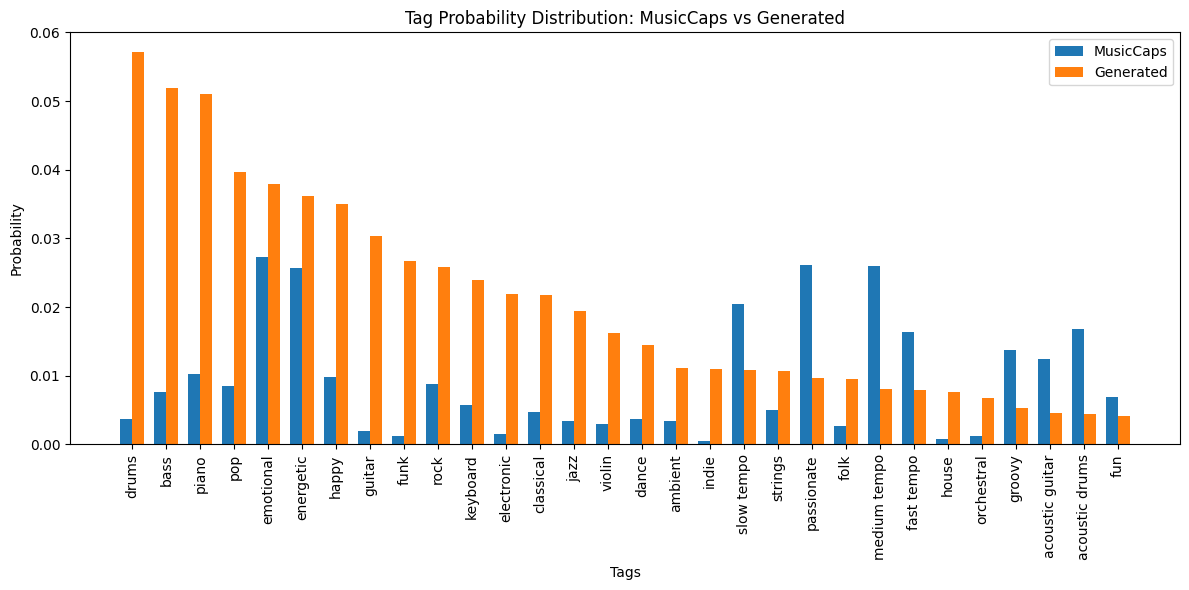

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
tags = list(set(list(musiccaps_tag_probs.keys()) + list(generated_tag_probs.keys())))
# get top 20 tags by musiccaps frequency
top_tags = sorted(generated_tag_probs.items(), key=lambda x: x[1], reverse=True)[:30]
top_tags = [tag for tag, prob in top_tags]
musiccaps_probs = [musiccaps_tag_probs.get(tag, 0) for tag in top_tags]
generated_probs = [generated_tag_probs.get(tag, 0) for tag in top_tags]
x = np.arange(len(top_tags))
width = 0.35
rects1 = ax.bar(x - width/2, musiccaps_probs, width, label='MusicCaps')
rects2 = ax.bar(x + width/2, generated_probs, width, label='Generated') 
ax.set_xlabel('Tags')
ax.set_ylabel('Probability')
ax.set_title('Tag Probability Distribution: MusicCaps vs Generated')
ax.set_xticks(x)
ax.set_xticklabels(top_tags, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()